Use information about previous time points to predict a subsequent time point.

In [8]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
   previous_values = series[:-1]
   last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
   percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
   return percent_change

prices_of_four = pd.read_csv('prices_of_four.csv', parse_dates=True, index_col=0)
display(prices_of_four)

ebay_prices = prices_of_four['EBAY']
prices_perc = ebay_prices.rolling(20).apply(percent_change)

prices_perc = prices_perc.loc["2014-01-02" :"2016-01-01"]
pd.to_datetime(prices_perc.index, utc=True)
prices_perc = prices_perc.to_frame()
display(prices_perc.info())

,EBAY,NVDA,YHOO,AAPL
date,,,,
2010-01-04,23.900000,18.490000,17.100000,214.009998
2010-01-05,23.650000,18.760000,17.230000,214.379993
2010-01-06,23.500000,18.879999,17.170000,210.969995
2010-01-07,23.229998,18.510000,16.700001,210.580000
2010-01-08,23.509999,18.549999,16.700001,211.980005
...,...,...,...,...
2016-12-23,29.790001,109.779999,38.660000,116.519997
2016-12-27,30.240000,117.320000,38.919998,117.260002
2016-12-28,30.010000,109.250000,38.730000,116.760002


/tmp/ipython-input-2450199663.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = series[-1]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2014-01-02 to 2015-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EBAY    504 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


None

In [5]:
aapl_prices = prices_of_four['AAPL']
prices_perc = aapl_prices.rolling(20).apply(percent_change)
prices_perc

/tmp/ipython-input-2450199663.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = series[-1]


,AAPL
date,
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,NaN
2010-01-08,NaN
...,...
2016-12-23,0.028989
2016-12-27,0.033147
2016-12-28,0.025982


In [7]:
mpl.rcParams['figure.figsize'] = (30, 30)
mpl.rcParams["xtick.labelsize"], mpl.rcParams["ytick.labelsize"] = 25,25
mpl.rcParams["legend.fontsize"] = 20

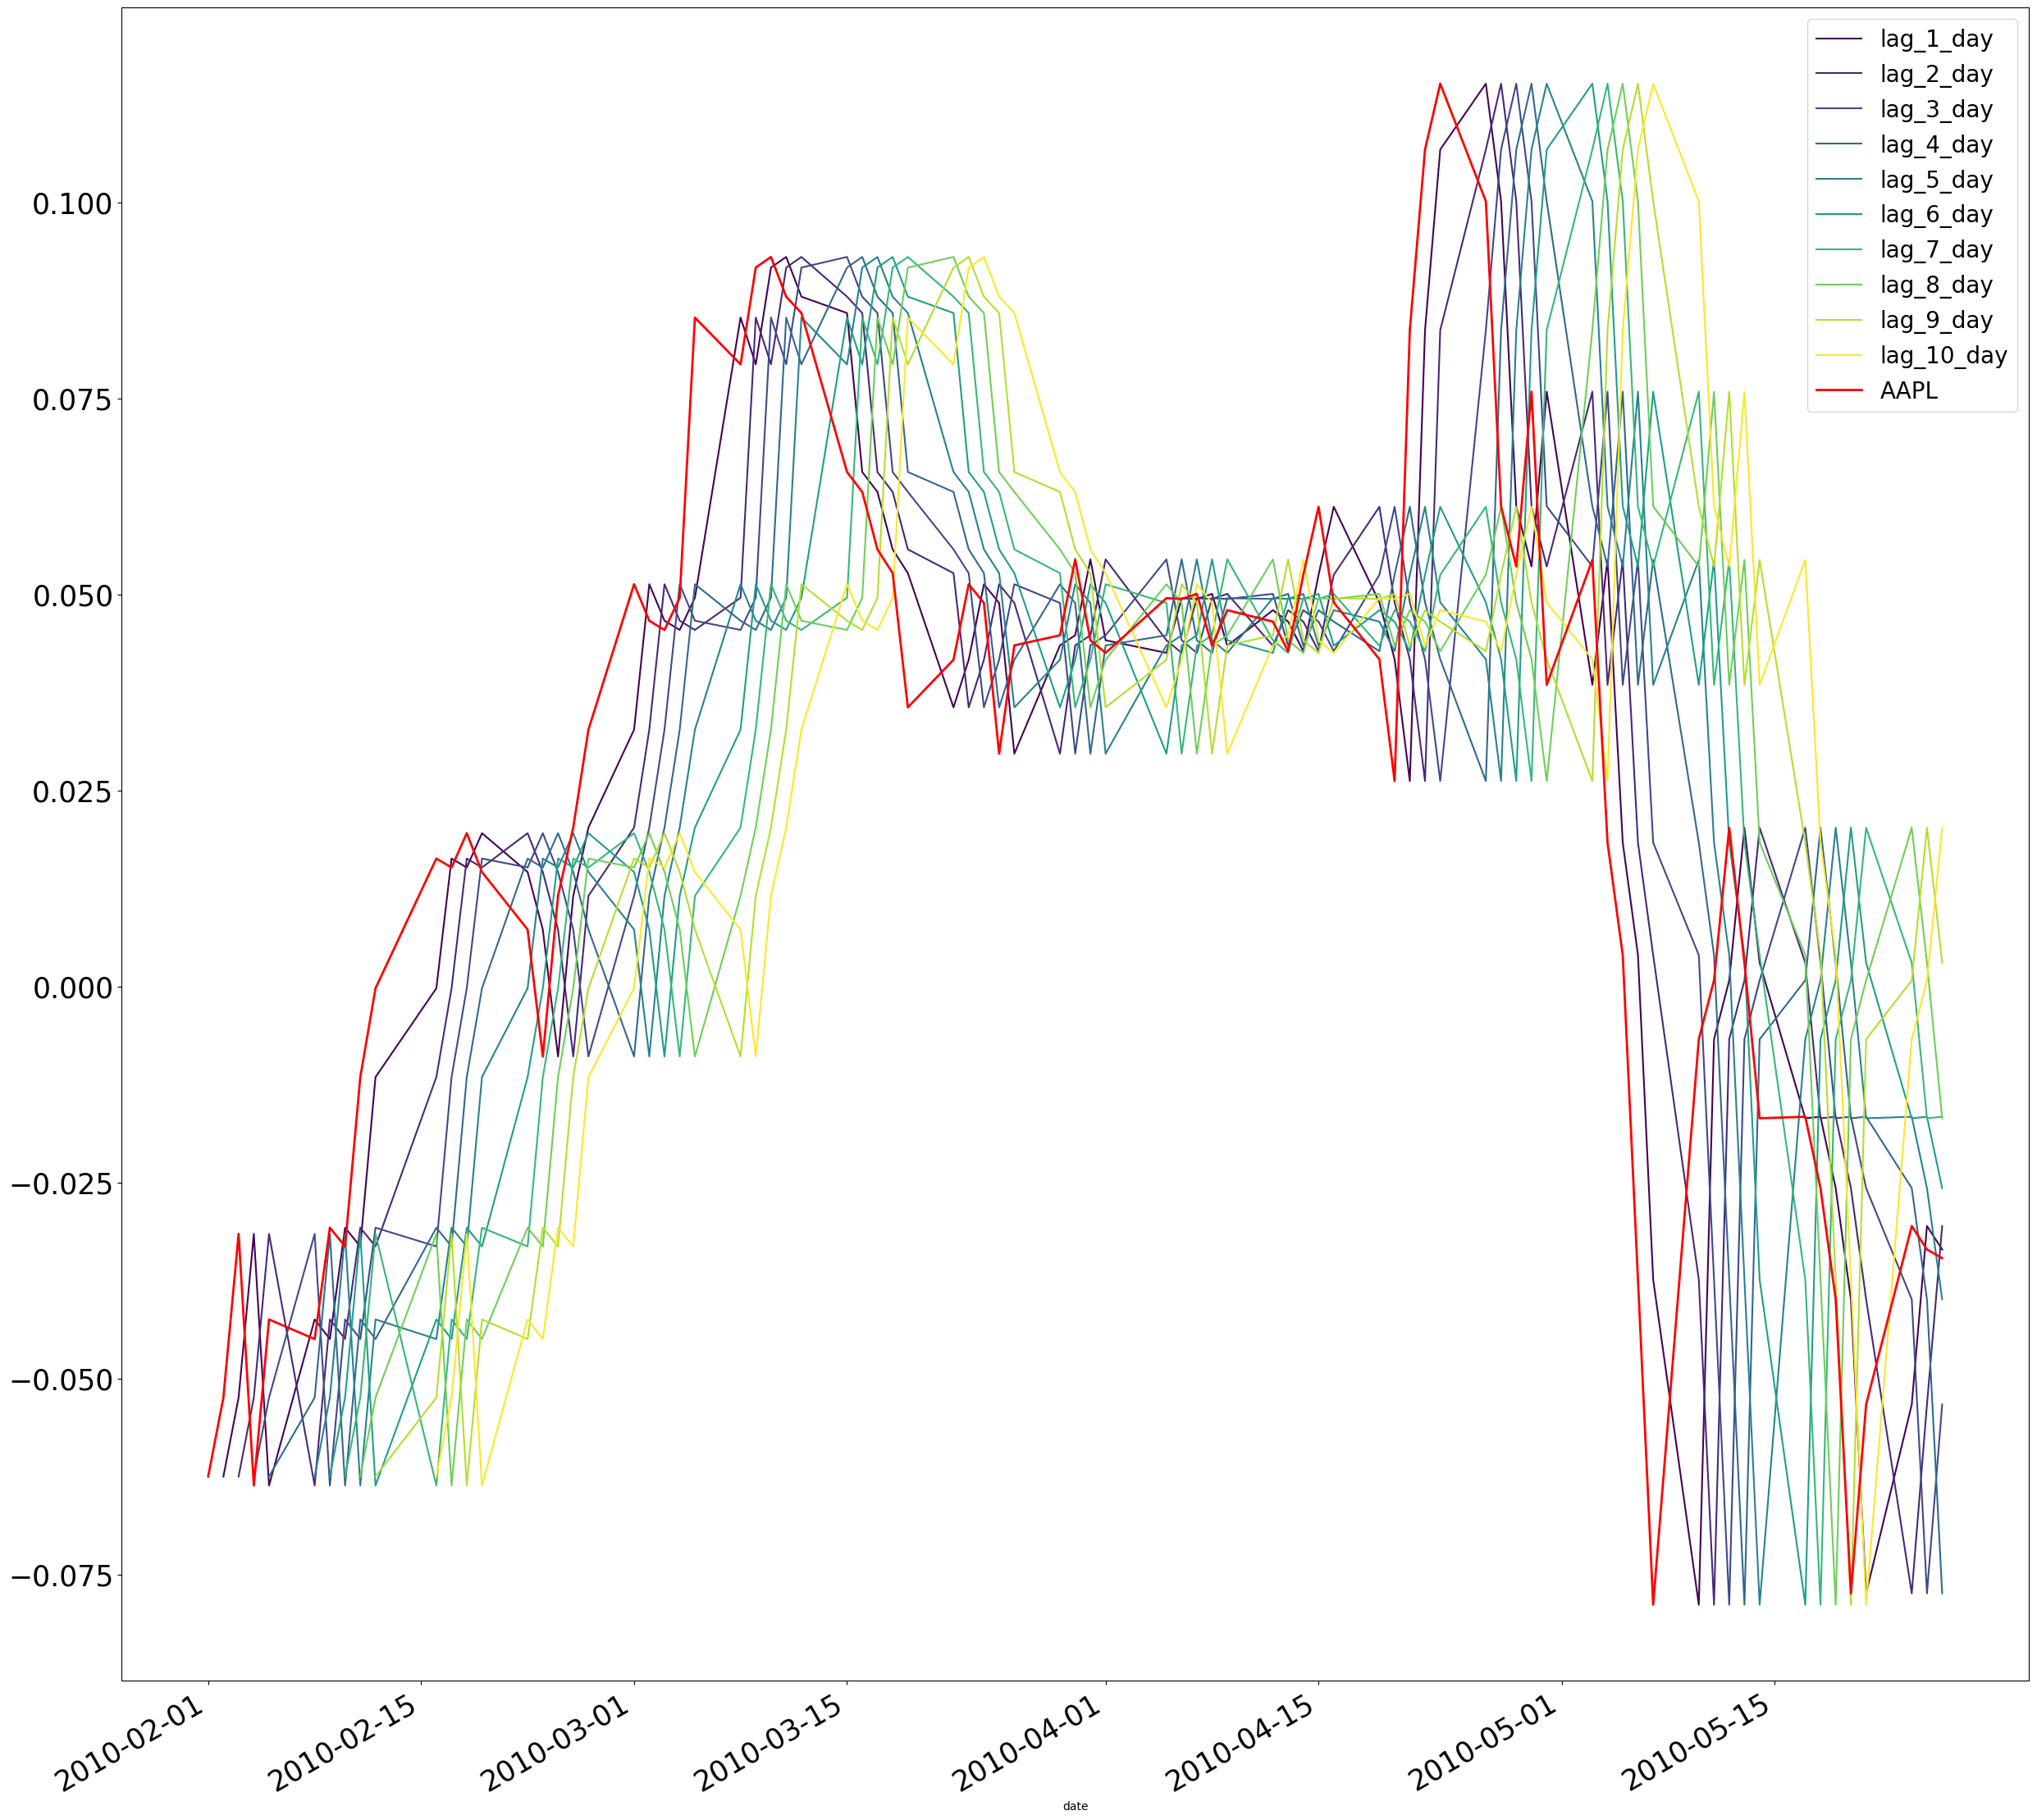

In [9]:
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

AUTO REGRESSIVE MODELS

In [10]:
aapl_prices = prices_of_four['AAPL']
prices_perc = aapl_prices.rolling(20).apply(percent_change)
prices_perc

# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

/tmp/ipython-input-2450199663.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = series[-1]


In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [12]:
# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)


Ridge()

You've filled in the missing values with the median so that it behaves well with scikit-learn.

Visualize regression coefficients

In [13]:
model.coef_

array([ 6.70669798e-01,  2.07062270e-01,  5.31249821e-02,  1.24128916e-02,
       -2.62606834e-04, -3.87075104e-04, -1.18883040e-02, -1.24028067e-02,
       -1.23756923e-02, -2.43236376e-02])

In [14]:
mpl.rcParams['axes.labelsize'] = 25
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')

    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

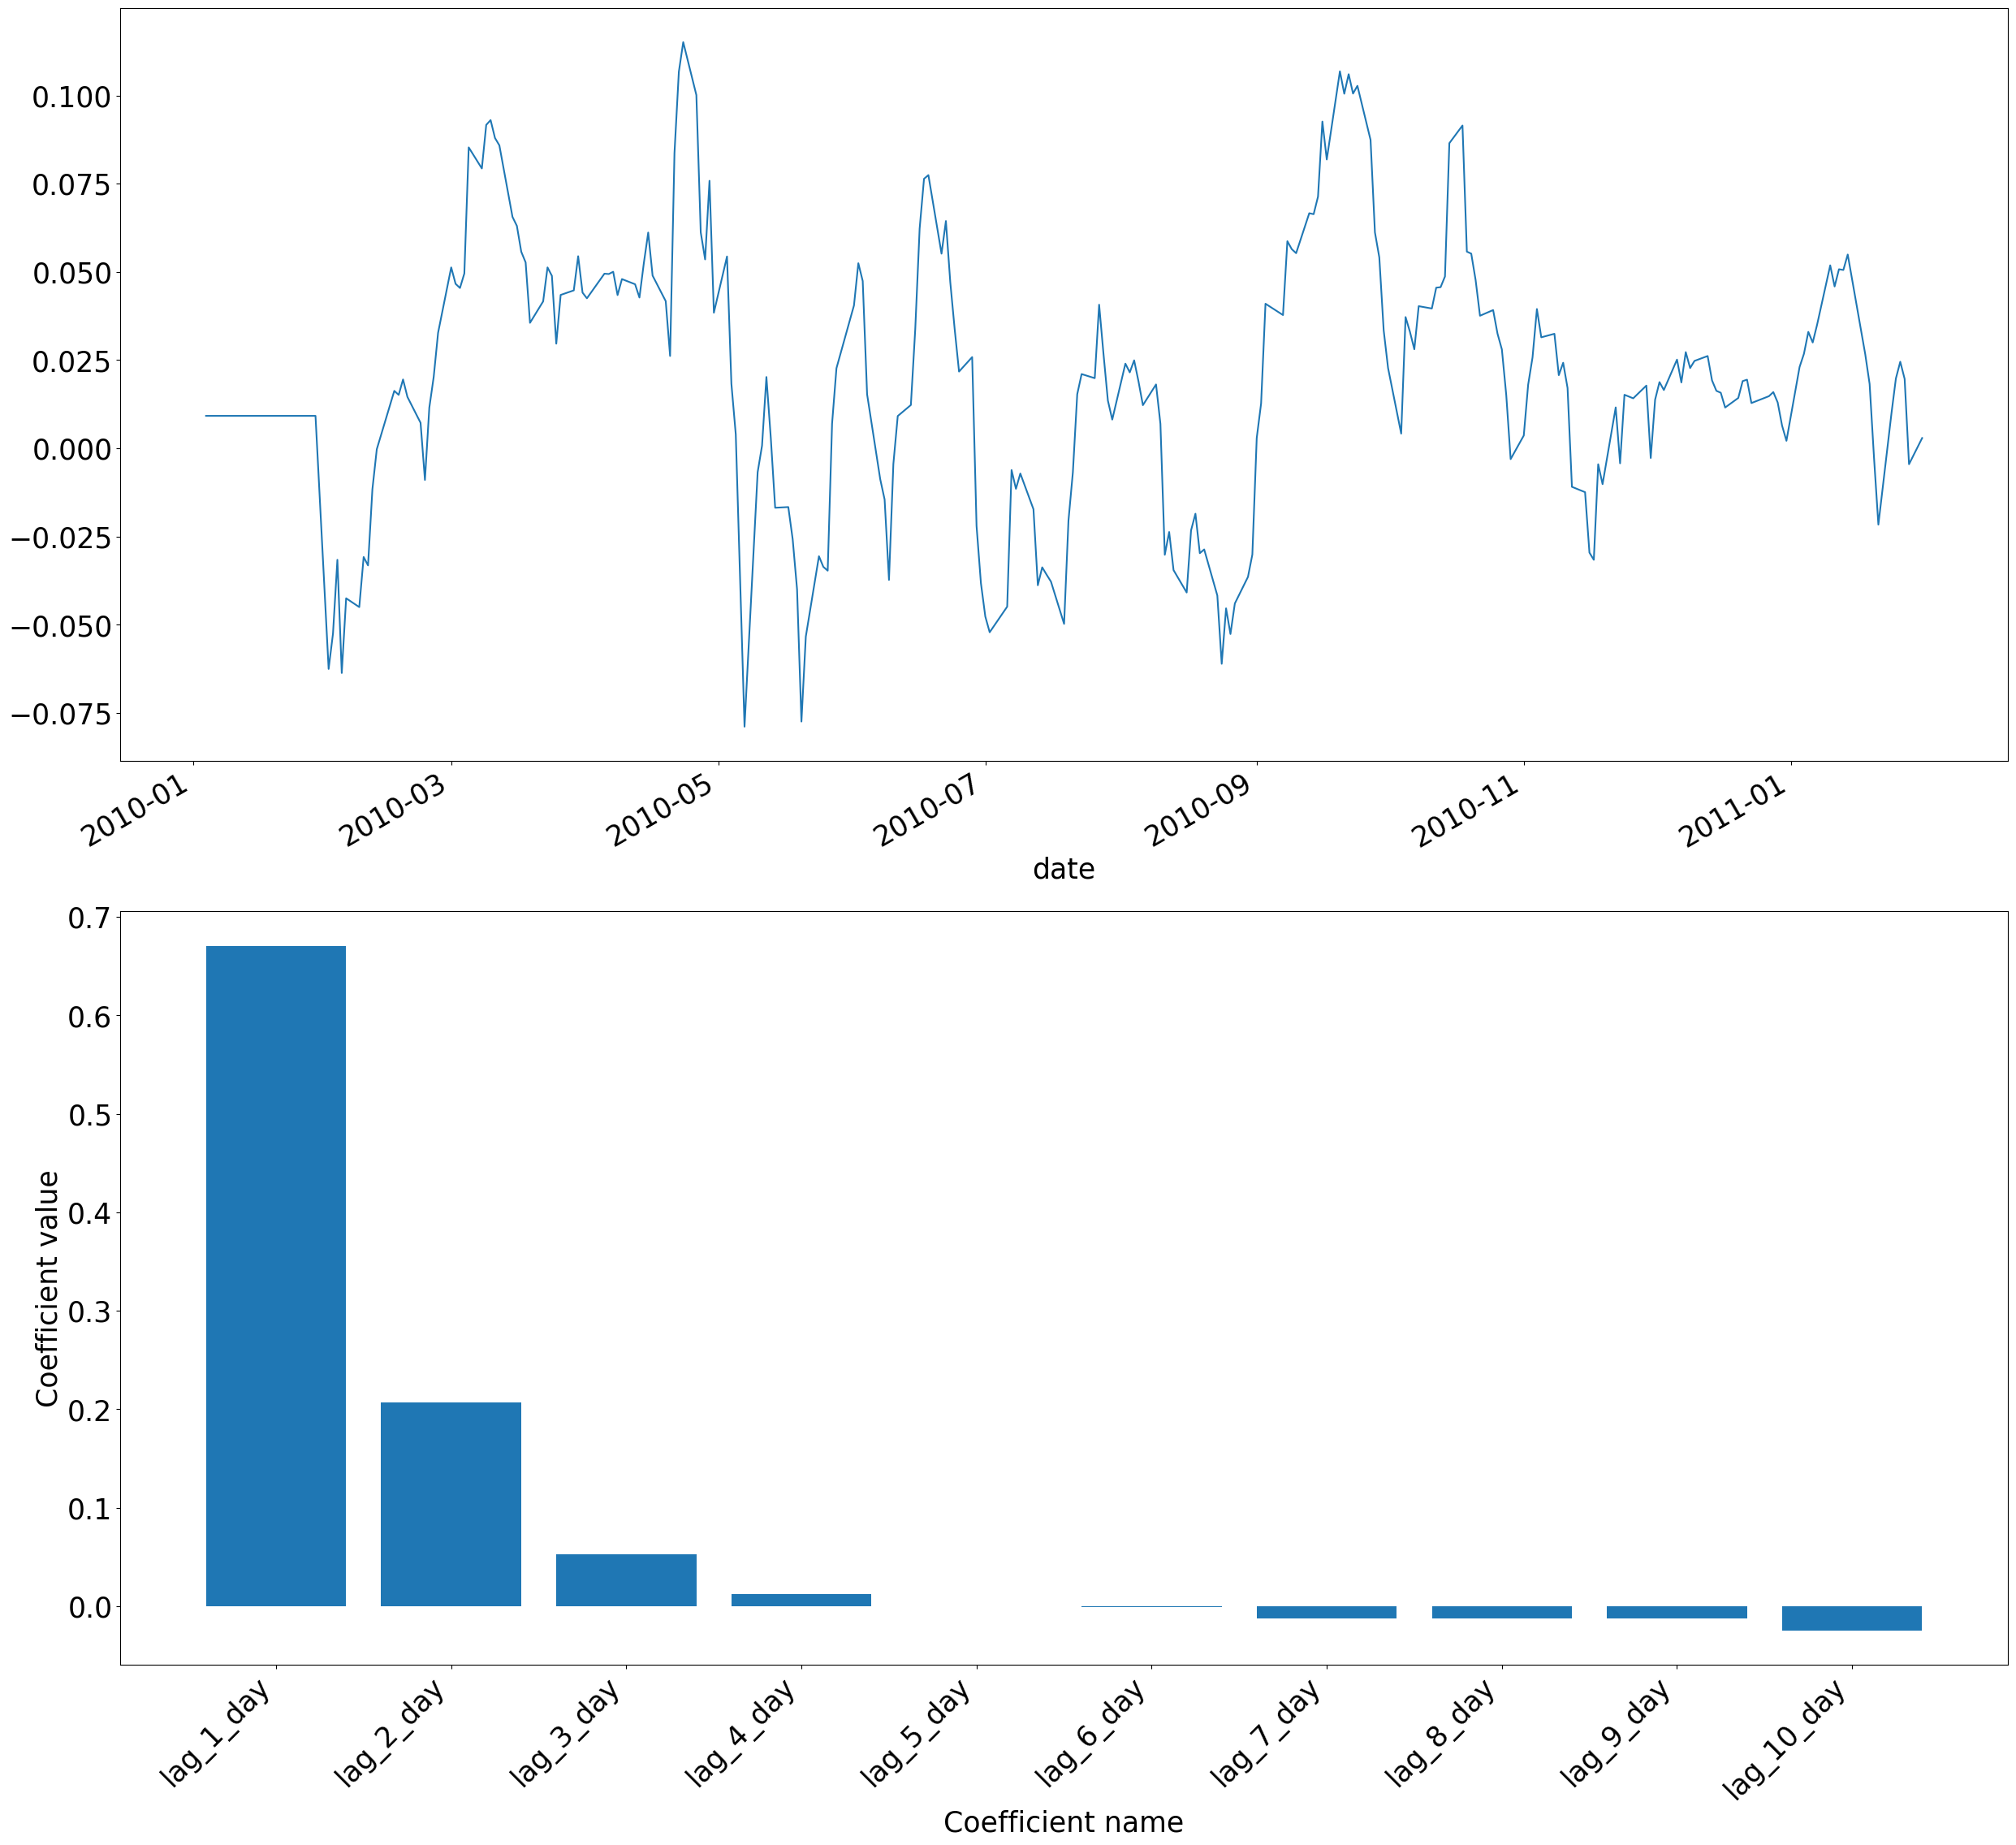

In [15]:
# Visualize the output data up to "2011-01"
# fig, axs = plt.subplots(2, 1, figsize=(10, 5))
fig, axs = plt.subplots(2, 1, figsize=(30, 30))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

When you use time-lagged features on the raw data, you see that the highest coefficient by far is the first one. This means that the N-1th time point is useful in predicting the Nth timepoint, but no other points are useful.

AUTO REGRESSION WITH A SMOOTHER TIME SERIES

Now, let's re-run the same procedure using a smoother signal. You'll use the same percent change algorithm as before, but this time use a much larger window (40 instead of 20). As the window grows, the difference between neighboring timepoints gets smaller, resulting in a smoother signal.

In [16]:
aapl_prices = prices_of_four['AAPL']
prices_perc = aapl_prices.rolling(40).apply(percent_change)
prices_perc

# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

/tmp/ipython-input-2450199663.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = series[-1]


Ridge()

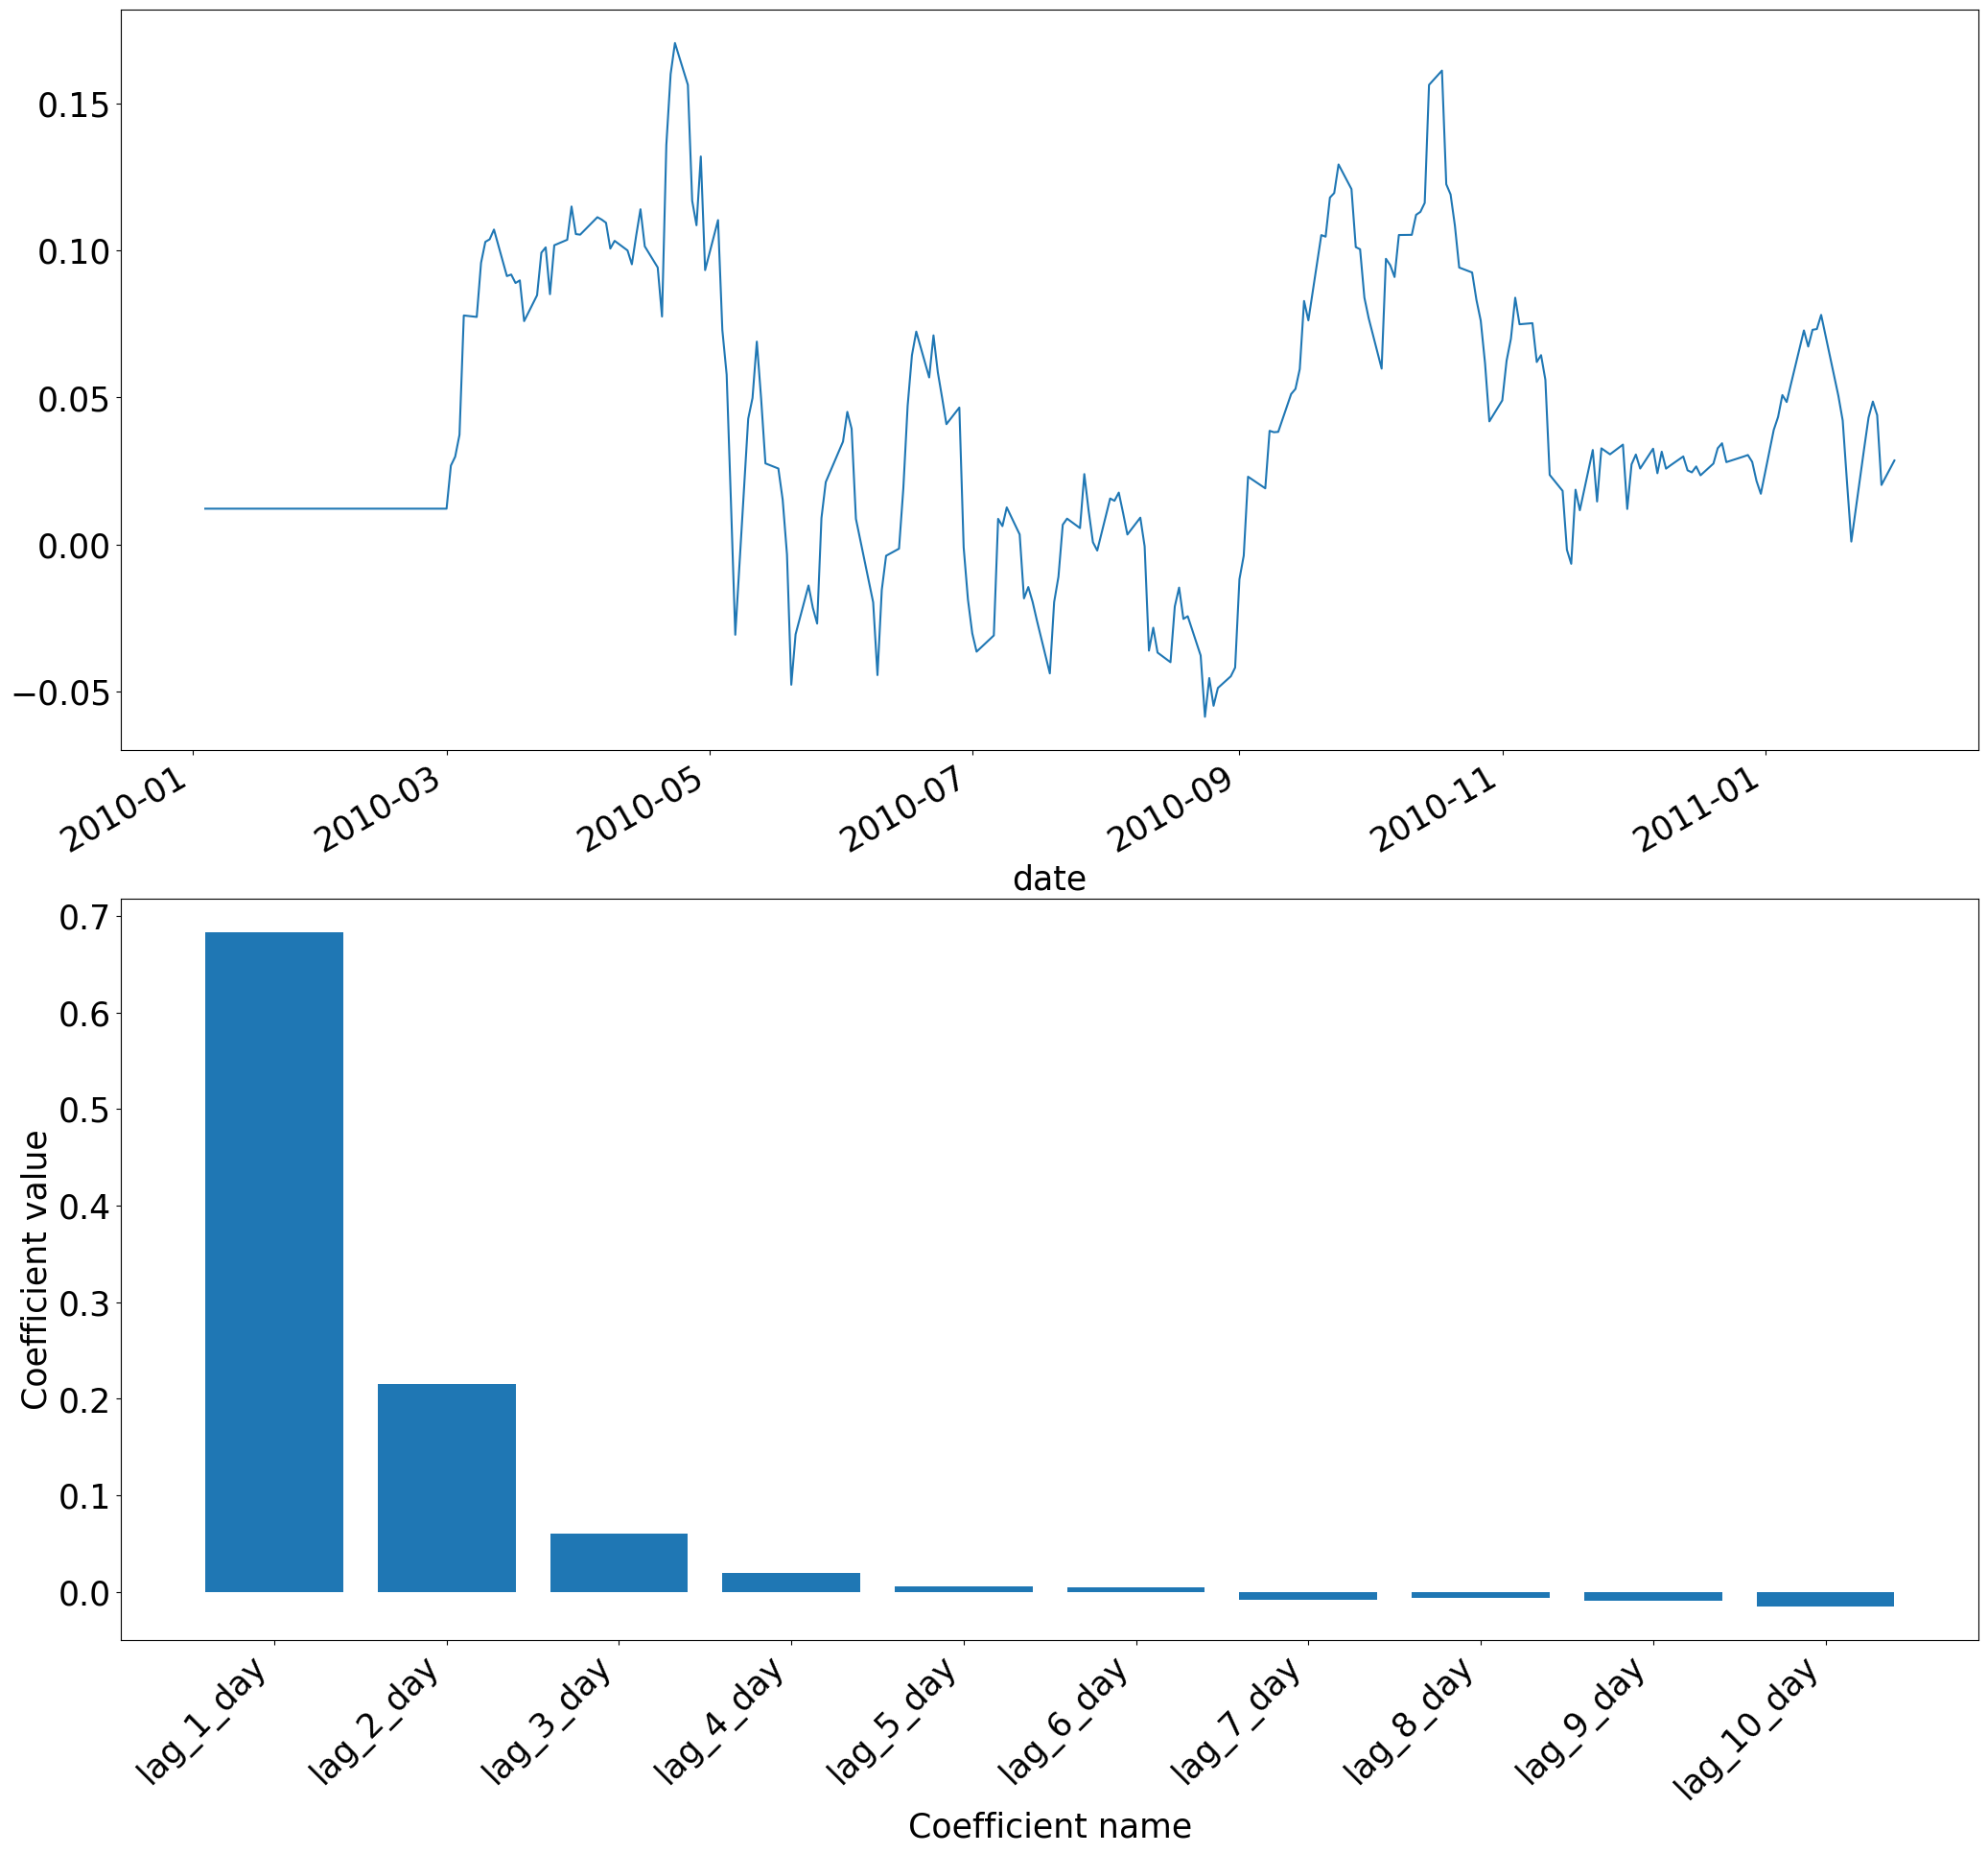

In [17]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(25, 25))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

As you can see here, by transforming your data with a larger window, you've also changed the relationship between each timepoint and the ones that come just before it. This model's coefficients gradually go down to zero, which means that the signal itself is smoother over time.

Cross-validation with shuffling

In [18]:
import itertools
import matplotlib.cm as cm


def visualize_predictions(results):
    viridis = cm.get_cmap('viridis', 12)
    colors = itertools.cycle(viridis(np.linspace(0, 1, len(results))))

    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Loop through our model results to visualize them (no need to show score)
    for ii, (prediction, indices, *score) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii

        c = next(colors)
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction, color=c ,label='Iteration {}'.format(ii))

        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction, color=c )
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")

    plt.show()

In [19]:
X_df = pd.read_csv('chap4_X.csv', index_col=[0])
y_df = pd.read_csv('chap4_y.csv', index_col=[0])

X, y = X_df.to_numpy(), y_df.to_numpy()
print(X.shape, y.shape)

(400, 10) (400, 1)


/tmp/ipython-input-3431333112.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', 12)


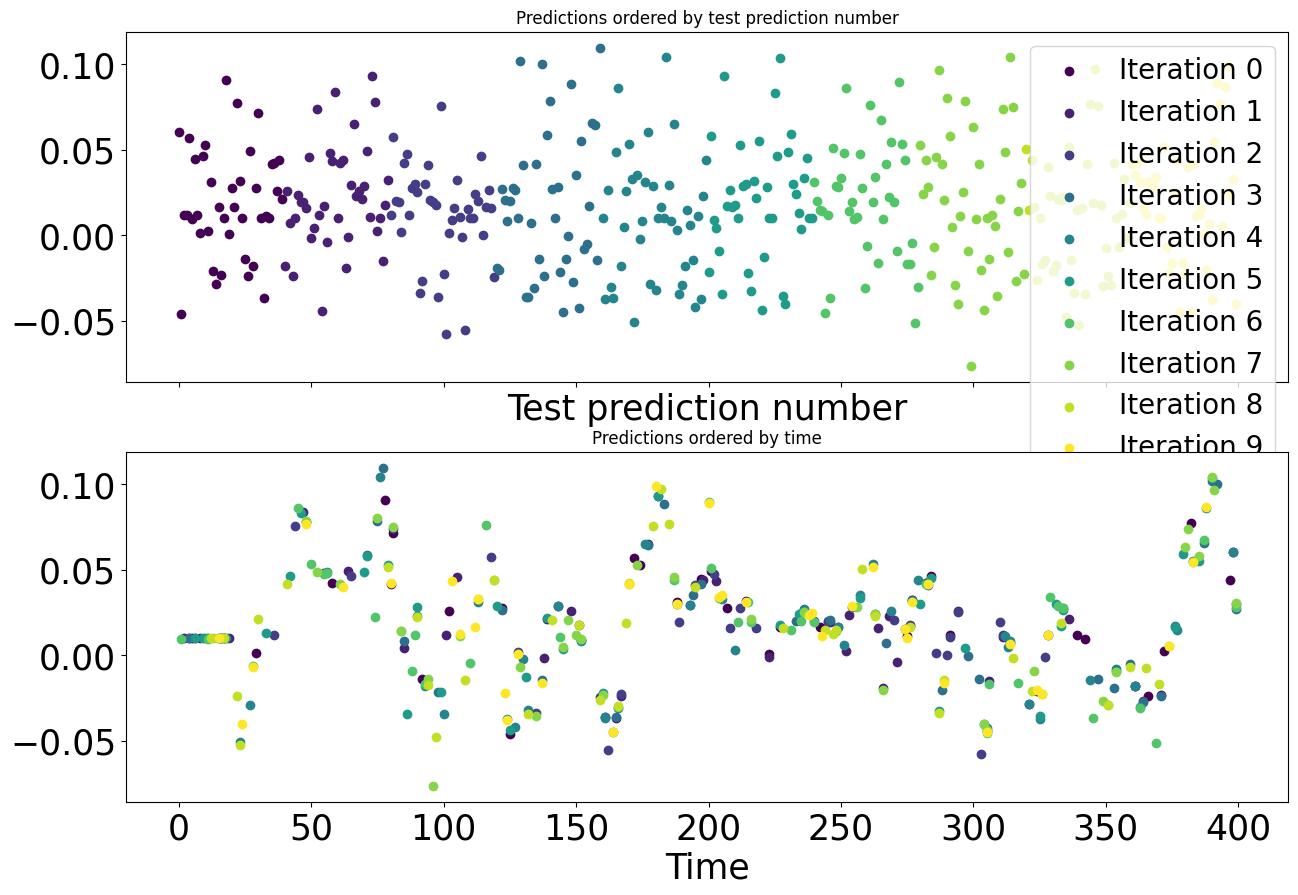

In [20]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
# Import ShuffleSplit and create the cross-validation object
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, random_state=1)


model = LinearRegression()
# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
   model.fit(X[tr], y[tr])

    # Generate predictions on the test data, score the predictions, and collect
   prediction = model.predict(X[tt])
   score = r2_score(y[tt], prediction)
   results.append((prediction, tt, score))

# Custom function to quickly visualize predictions
visualize_predictions(results)

 Order of datapoints in the test set is scrambled

/tmp/ipython-input-3431333112.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', 12)


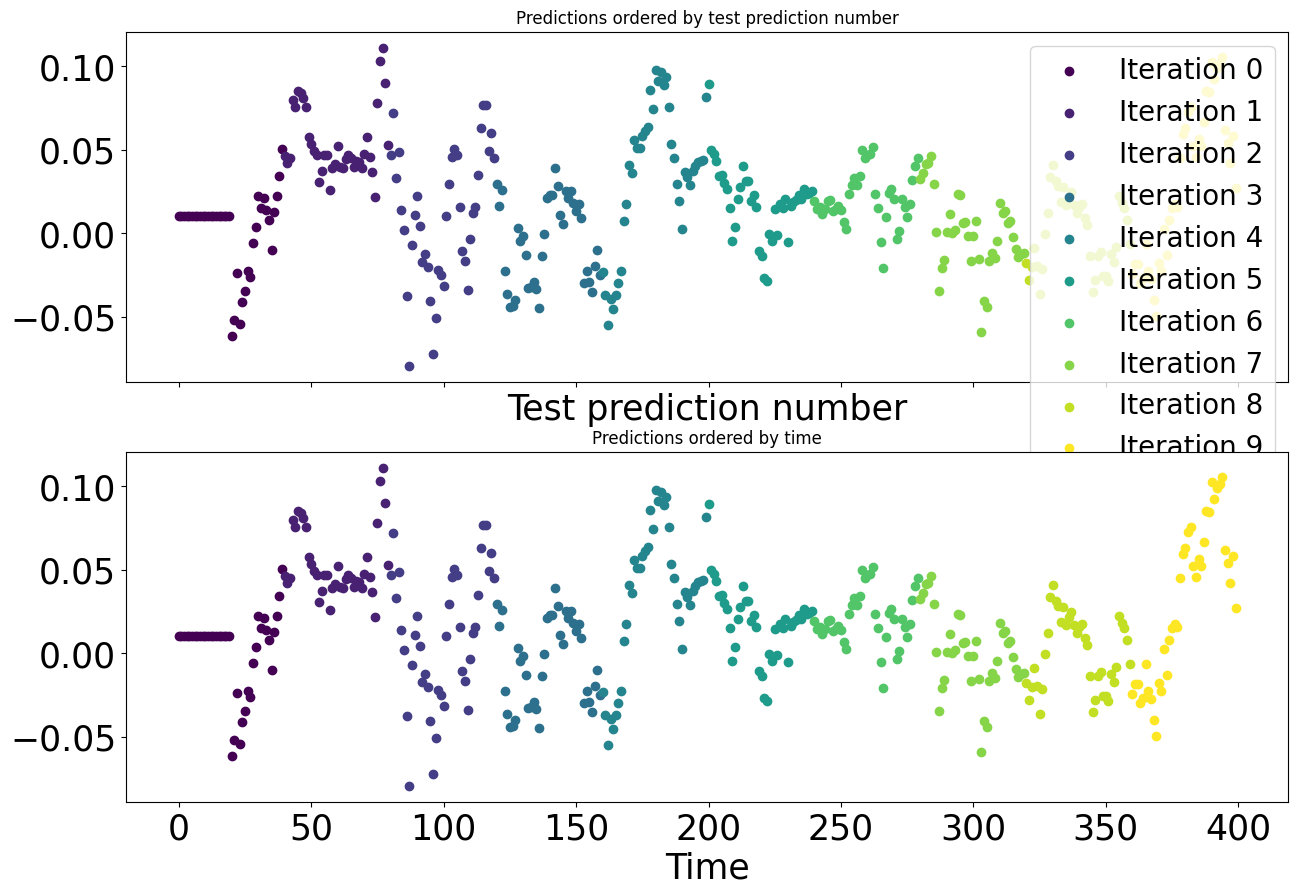

In [21]:
# Create KFold cross-validation object
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])

    # Generate predictions on the test data and collect
    prediction = model.predict(X[tt])
    results.append((prediction, tt))

# Custom function to quickly visualize predictions
visualize_predictions(results)

This time, the predictions generated within each CV loop look 'smoother' than they were before - they look more like a real time series because you didn't shuffle the data.

 Let's visualize the behavior of the time series cross-validation iterator in scikit-learn

In [23]:
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (12, 8)

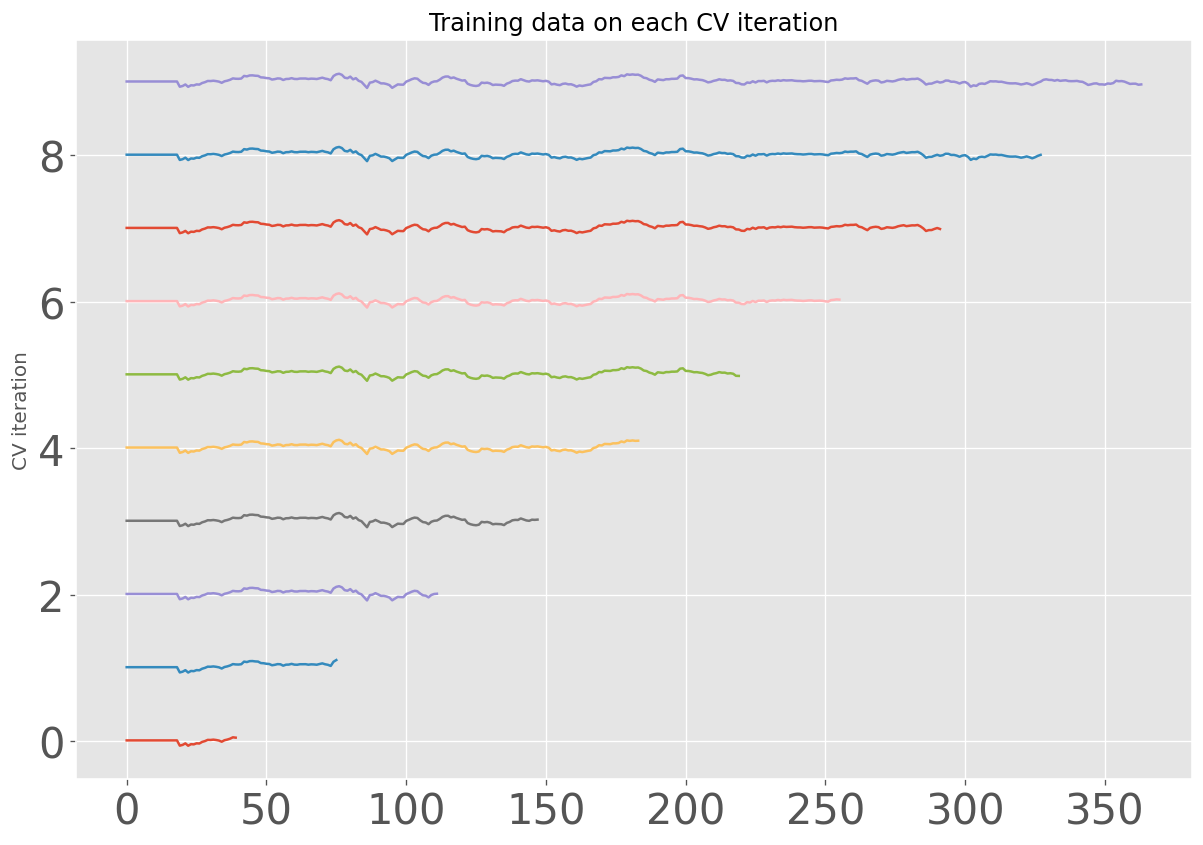

In [24]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

Note that the size of the training set grew each time when you used the time series cross-validation object. This way, the time points you predict are always after the timepoints we train on

A useful tool for assessing the variability of some data is the bootstrap.

In [25]:
from sklearn.utils import resample

def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
   """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create empty array to fill the results
   bootstrap_means = np.zeros([n_boots, data.shape[-1]])
   for ii in range(n_boots):
        # Generate random indices for data *with* replacement, then take the sample mean
       random_sample = resample(data)
       bootstrap_means[ii] = random_sample.mean(axis=0)

    # Compute the percentiles of choice for the bootstrapped means
   percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
   return percentiles

In [26]:
model = LinearRegression()
X_df = pd.read_csv('chap4_X_stationarity.csv', index_col=[0])
y_df = pd.read_csv('chap4_y_stationarity.csv', index_col=[0])

X, y = X_df.to_numpy(), y_df.to_numpy()
print(X.shape, y.shape)

(1762, 12) (1762, 1)


In [27]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
   model.fit(X[tr], y[tr])
   coefficients[ii] = model.coef_

In [28]:
feature_names = ['AAPL_lag_1_day', 'YHOO_lag_1_day', 'NVDA_lag_1_day', 'AAPL_lag_2_day', 'YHOO_lag_2_day', 'NVDA_lag_2_day', 'AAPL_lag_3_day', 'YHOO_lag_3_day', 'NVDA_lag_3_day', 'AAPL_lag_4_day',
       'YHOO_lag_4_day', 'NVDA_lag_4_day']

plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (7, 5)

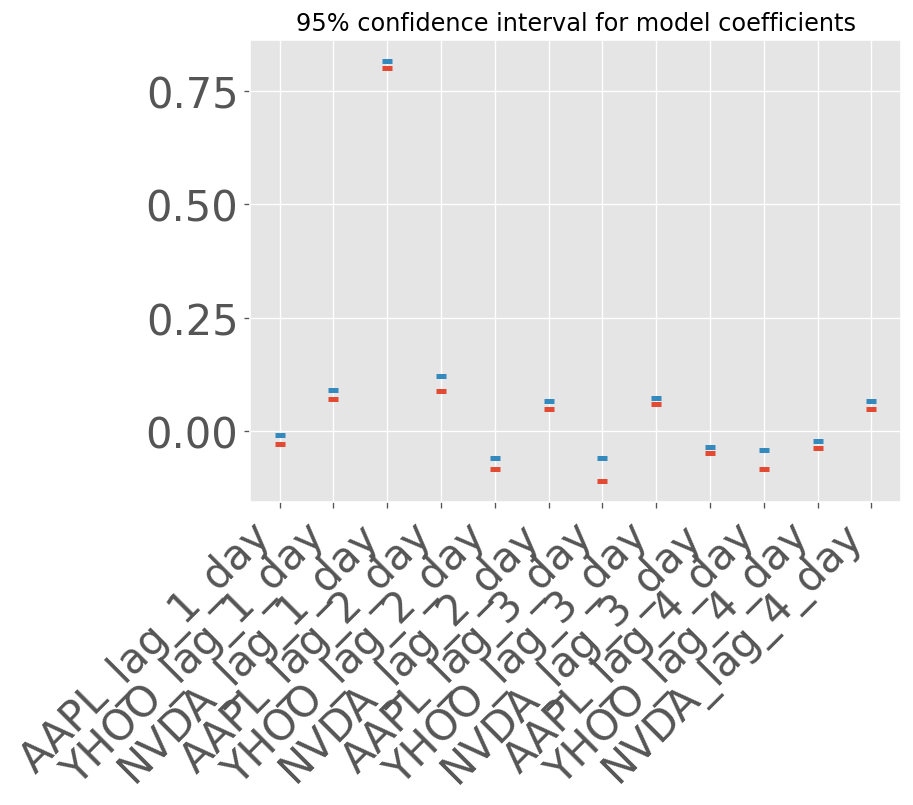

In [29]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)


# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()


 We calculated the variability around each coefficient, which helps assess which coefficients are more stable over time

Let's do the same for the performance (scores) of the model

In [30]:
# Read in the data
prices  = pd.read_csv('prices_aapl_yhoo_nvda.csv', index_col=[0])
prices_perc = prices.rolling(20).apply(percent_change)

shifts = np.arange(1, 5).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"{}_lag_{}_day".format(col,day_shift): prices_perc[col].shift(day_shift) for day_shift in shifts for col in prices_perc.columns}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)
display(prices_perc_shifted)

/tmp/ipython-input-2450199663.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = series[-1]


,AAPL_lag_1_day,YHOO_lag_1_day,NVDA_lag_1_day,AAPL_lag_2_day,YHOO_lag_2_day,NVDA_lag_2_day,AAPL_lag_3_day,YHOO_lag_3_day,NVDA_lag_3_day,AAPL_lag_4_day,YHOO_lag_4_day,NVDA_lag_4_day
date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,0.029110,-0.044952,0.127842,0.038745,-0.031117,0.121737,0.040271,-0.033199,0.121952,0.039904,-0.054773,0.089479
2016-12-27,0.028989,-0.038006,0.147720,0.029110,-0.044952,0.127842,0.038745,-0.031117,0.121737,0.040271,-0.033199,0.121952
2016-12-28,0.033147,-0.027985,0.216063,0.028989,-0.038006,0.147720,0.029110,-0.044952,0.127842,0.038745,-0.031117,0.121737


In [32]:
from functools import partial

model = LinearRegression()
X_df = pd.read_csv('chap4_X_stationarity.csv', index_col=[0])


y_df = pd.read_csv('test_y.csv', index_col=[0])

X, y = X_df.to_numpy(), y_df.to_numpy()
print(X.shape, y.shape)

times_scores = pd.DatetimeIndex(
        ['2010-04-05', '2010-04-28', '2010-05-21', '2010-06-16', '2010-07-12','2010-08-04', '2010-08-27', '2010-09-22', '2010-10-15', '2010-11-09', '2010-12-03', '2010-12-29', '2011-01-24','2011-02-16', '2011-03-14', '2011-04-06', '2011-05-02', '2011-05-25', '2011-06-20', '2011-07-14', '2011-08-08', '2011-08-31', '2011-09-26', '2011-10-19', '2011-11-11', '2011-12-07','2012-01-03', '2012-01-27', '2012-02-22', '2012-03-16', '2012-04-11', '2012-05-04', '2012-05-30', '2012-06-22', '2012-07-18', '2012-08-10', '2012-09-05', '2012-09-28', '2012-10-23','2012-11-19', '2012-12-13', '2013-01-09', '2013-02-04', '2013-02-28', '2013-03-25', '2013-04-18', '2013-05-13', '2013-06-06', '2013-07-01', '2013-07-25', '2013-08-19', '2013-09-12','2013-10-07', '2013-10-30', '2013-11-22', '2013-12-18', '2014-01-14', '2014-02-07', '2014-03-05', '2014-03-28', '2014-04-23', '2014-05-16', '2014-06-11', '2014-07-07', '2014-07-30','2014-08-22', '2014-09-17', '2014-10-10', '2014-11-04', '2014-11-28', '2014-12-23', '2015-01-20', '2015-02-12', '2015-03-10', '2015-04-02', '2015-04-28', '2015-05-21', '2015-06-16','2015-07-10', '2015-08-04', '2015-08-27', '2015-09-22', '2015-10-15', '2015-11-09', '2015-12-03', '2015-12-29', '2016-01-25', '2016-02-18', '2016-03-14', '2016-04-07', '2016-05-02','2016-05-25', '2016-06-20', '2016-07-14', '2016-08-08', '2016-08-31', '2016-09-26', '2016-10-19', '2016-11-11', '2016-12-07'], dtype='datetime64[ns]', name='date', freq=None)

(1762, 12) (1762, 1)


In [33]:
def my_pearsonr(est, X, y):
    return np.corrcoef(est.predict(X).squeeze(), y.squeeze())[1, 0]

def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 1- or 2-D dataset."""
    # Create our empty array we'll fille with the results
    if data.ndim == 1:
        data = np.array(data)[:, np.newaxis]
    data = np.atleast_2d(data)
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

In [34]:
plt.style.use('default')
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (12, 12)

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

model = LinearRegression()

# Iterate through CV splits
cv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=100, test_size=None)

# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
scores


# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')


# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

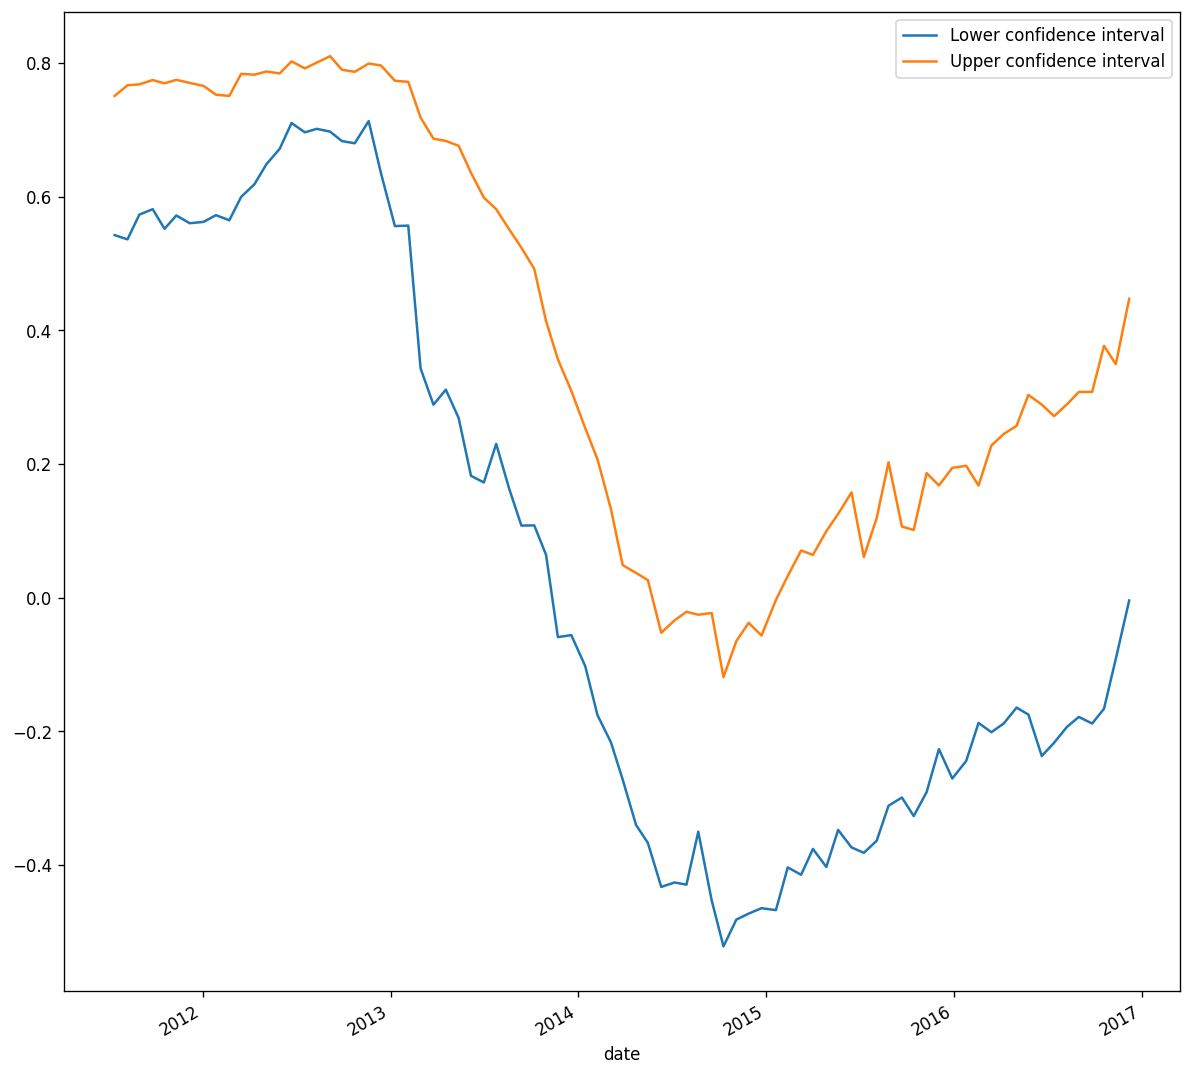

In [36]:
# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label="Lower confidence interval")
scores_hi.plot(ax=ax, label="Upper confidence interval")
ax.legend()
plt.show()

This is useful in seeing when your model predictions are correct.

We will again visualize the variations in model scores, but now for data that changes its statistics over time.

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

model = LinearRegression()

X_df = pd.read_csv('non_stationarity_X.csv', index_col=[0])
y_df = pd.read_csv('non_stationarity_y.csv', index_col=[0])

X, y = X_df.to_numpy(), y_df.to_numpy()

In [39]:
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)

    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

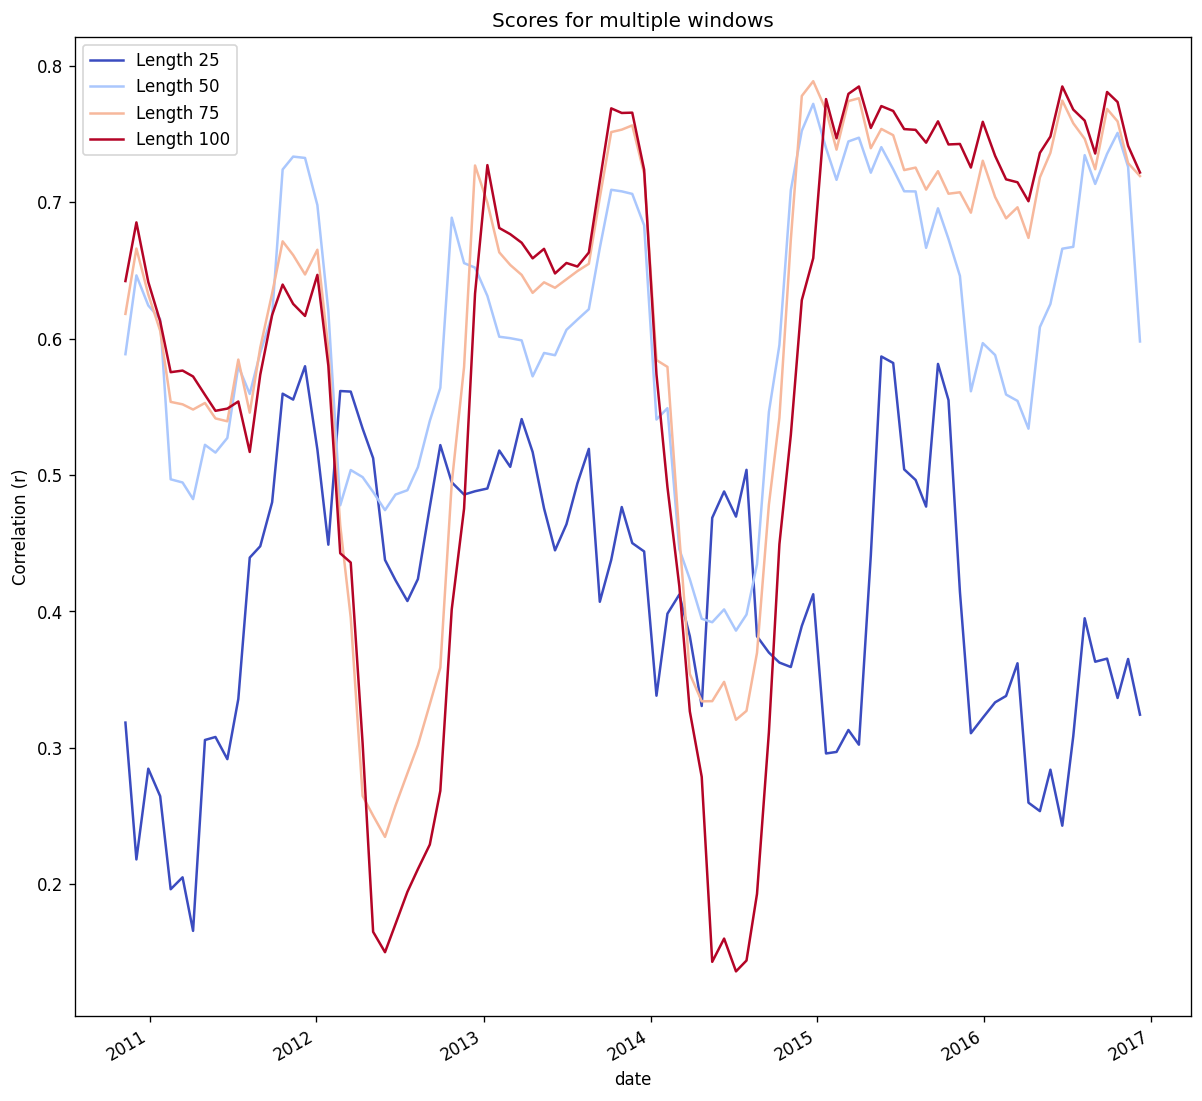

In [40]:
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')
plt.show()

Notice how in some stretches of time, longer windows perform worse than shorter ones. This is because the statistics in the data have changed, and the longer window is now using outdated information.